# HR Analytics Hackathon Project

This is project done as a part of a Hackathan Project organized by Analytics Vidya (https://datahack.analyticsvidhya.com/contest/wns-analytics-hackathon-2018-1/).
In this problem we are trying to predict whether an employee will get promotion or not on the basis of provided data set.

In [1]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report,confusion_matrix

from sklearn.metrics import classification_report,confusion_matrix

import warnings
warnings.simplefilter('ignore')

In [2]:
#Loading the dataframe

train_data = pd.read_csv('train_LZdllcl.csv')
test_data = pd.read_csv('test_2umaH9m.csv')

In [3]:
#Geting details of the train data frame

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [4]:
#Having the summary of train data

train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
employee_id,54808.0,39195.830627,22586.581449,1.0,19669.75,39225.5,58730.5,78298.0
no_of_trainings,54808.0,1.253011,0.609264,1.0,1.00,1.0,1.0,10.0
age,54808.0,34.803915,7.660169,20.0,29.00,33.0,39.0,60.0
previous_year_rating,50684.0,3.329256,1.259993,1.0,3.00,3.0,4.0,5.0
length_of_service,54808.0,5.865512,4.265094,1.0,3.00,5.0,7.0,37.0
KPIs_met >80%,54808.0,0.351974,0.477590,0.0,0.00,0.0,1.0,1.0
awards_won?,54808.0,0.023172,0.150450,0.0,0.00,0.0,0.0,1.0
avg_training_score,54808.0,63.386750,13.371559,39.0,51.00,60.0,76.0,99.0
is_promoted,54808.0,0.085170,0.279137,0.0,0.00,0.0,0.0,1.0


In [5]:
#Chanding the name of the 'KPIs_met >80%','awards_won?' columns

train_data.rename(columns={'KPIs_met >80%':'KPI','awards_won?':'awards'},inplace =True)

test_data.rename(columns={'KPIs_met >80%':'KPI','awards_won?':'awards'}, inplace =True)

In [6]:
#Checking first 5 rows of the train data

train_data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPI,awards,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [7]:
#Checking for the Null

train_data.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPI                        0
awards                     0
avg_training_score         0
is_promoted                0
dtype: int64

In [8]:
# filling null values with 0 for previous_year_rating

train_data.previous_year_rating.fillna(0,inplace=True)
test_data.previous_year_rating.fillna(0,inplace=True)

In [9]:
# filling null values with ffill for education

train_data.education.ffill(inplace=True)
test_data.education.ffill(inplace=True)

In [10]:
#Getting all Categorical columns

cat_col = [var for var in train_data.columns if train_data[var].dtypes == 'O']

In [11]:
# function to create Dummies for Categorical columns

for var in cat_col:
    
    # to create the binary variables, we use get_dummies from pandas
    
    train_data = pd.concat([train_data,
                         pd.get_dummies(train_data[var], prefix=var)
                         ], axis=1)
    
    test_data = pd.concat([test_data,
                        pd.get_dummies(test_data[var], prefix=var)
                        ], axis=1)
    

In [12]:
# Bining age in 4 groups for Train

train_data['age_bin'] = train_data.age.apply(lambda x : 'junior' if x in range(20,25) else (
'intermediate' if x in range(25,35) else(
'senior' if x in range(35,45) else 'supersenior')))

train_data = pd.concat([train_data,pd.get_dummies(train_data.age_bin, prefix='age')],axis=1) 

In [13]:
# Bining age in 4 groups for Test

test_data['age_bin'] = test_data.age.apply(lambda x : 'junior' if x in range(20,25) else (
'intermediate' if x in range(25,35) else(
'senior' if x in range(35,45) else 'supersenior')))

test_data = pd.concat([test_data,pd.get_dummies(test_data.age_bin, prefix='age')],axis=1) 

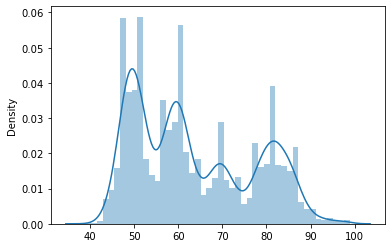

In [14]:
#Visualizing the distriution for avg_training_score

sns.distplot(x=train_data['avg_training_score'])

In [15]:
# Binning on the basis of multimodal distplot indicating 4 different groups
binedges=[38,55,65,75,99]
binlabels=[1,2,3,4]
train_data['cat_avg_training_score']=pd.cut(train_data['avg_training_score'],bins=binedges,labels=binlabels)

In [16]:
# Binning on the basis of multimodal distplot indicating 4 different groups
binedges=[38,55,65,75,99]
binlabels=[1,2,3,4]
test_data['cat_avg_training_score']=pd.cut(test_data['avg_training_score'],bins=binedges,labels=binlabels)

In [17]:
#Creating new feature for vital fields for prediction

#Field created using KPI and previous_year_rating
train_data['Rating_KPI'] = train_data.KPI*train_data.previous_year_rating
test_data['Rating_KPI'] = test_data.KPI*test_data.previous_year_rating

#Field created using KPI and awards
train_data['awards_KPI'] = train_data.KPI*train_data.awards
test_data['awards_KPI'] = test_data.KPI*test_data.awards

#Field created using KPI ,previous_year_rating and awards
train_data['sum_performance'] = train_data.KPI + train_data.previous_year_rating + train_data.awards
test_data['sum_performance'] = test_data.KPI + test_data.previous_year_rating + test_data.awards

#Creating the start year field
train_data['start_year'] = train_data['age'] - train_data['length_of_service']
test_data['start_year'] = test_data['age'] - test_data['length_of_service']

In [19]:
# train_data['work_fraction'] = train_data['length_of_service'] / train_data['age']
# test_data['work_fraction'] = test_data['length_of_service'] / test_data['age']
# train_data['key_promotion'] 

In [20]:
#Droping unnecessary columns from train
train_data.drop(['employee_id','department', 'region', 'education', 'gender','recruitment_channel','department','region','age_bin','age'],axis=1,inplace=True)

In [21]:
#Droping unnecessary columns from test
test_data_cleaned = test_data.drop(['employee_id','department', 'region', 'education', 'gender','recruitment_channel','department','region','age_bin','age'],axis=1)

In [22]:
#Getting all features
features = [var for var in train_data.columns if var !='is_promoted']

#Applying PCA
pca = PCA(n_components=1)
pca.fit(train_data[features])

#Adding PCA as a feature to train and test dataset
train_data['pca'] = pca.transform(train_data[features])
test_data_cleaned['pca'] = pca.transform(test_data_cleaned)

In [23]:
#Function to split train and test dataset

def data_prepration(x): # preparing data for training and testing as we are going to use different data 
    #again and again so make a function
    x_features= x.iloc[:,x.columns != "is_promoted"]
    x_labels=x.iloc[:,x.columns=="is_promoted"]
    x_features_train,x_features_test,x_labels_train,x_labels_test = train_test_split(x_features,x_labels,test_size=0.25,random_state=42)
    print("length of training data")
    print(len(x_features_train))
    print("length of test data")
    print(len(x_features_test))
    return(x_features_train,x_features_test,x_labels_train,x_labels_test)

In [24]:
# Lets Use SMOTE for Sampling

os = SMOTE(random_state=0) #   We are using SMOTE as the function for oversampling
# now we can devided our data into training and test data
# Call our method data prepration on our dataset
data_train_X,data_test_X,data_train_y,data_test_y=data_prepration(train_data)
columns = data_train_X.columns

length of training data
41106
length of test data
13702


In [25]:
#Scaling the Datadset with StandardScaler

#Getting all cols
all_col = [var for var in data_train_X.columns] 

#Initializing Standerd Scaller
scaler = StandardScaler()

#Fitting train_data to standerd Scaller
scaler.fit(data_train_X[all_col])

#transforming data with Standerd/scalar
data_train_X[all_col] = scaler.transform(data_train_X[all_col])
data_test_X[all_col] = scaler.transform(data_test_X[all_col])
test_data_cleaned[all_col] = scaler.transform(test_data_cleaned[all_col])

In [26]:
# now use SMOTE to oversample our train data which have features data_train_X and labels in data_train_y

os_data_X,os_data_y=os.fit_sample(data_train_X,data_train_y)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=["is_promoted"])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of normal transcation in oversampled data",len(os_data_y[os_data_y["is_promoted"]==0]))
print("No.of fraud transcation",len(os_data_y[os_data_y["is_promoted"]==1]))
print("Proportion of Normal data in oversampled data is ",len(os_data_y[os_data_y["is_promoted"]==0])/len(os_data_X))
print("Proportion of fraud data in oversampled data is ",len(os_data_y[os_data_y["is_promoted"]==1])/len(os_data_X))

length of oversampled data is  75138
Number of normal transcation in oversampled data 37569
No.of fraud transcation 37569
Proportion of Normal data in oversampled data is  0.5
Proportion of fraud data in oversampled data is  0.5


In [27]:
#Hyperparameter tuning for XGB model

def hyperParameterTuning(X_train, y_train):
    
    param_tuning = {
#         'learning_rate': [0.01, 0.1,0.3],
        'learning_rate': [0.01, 0.05,0.1],
#         'max_depth': [3, 5, 7, 10],
        'max_depth': [ 7, 10,12],
#         'min_child_weight': [1, 3, 5],
#         'subsample': [0.5, 0.7],
#         'colsample_bytree': [0.5, 0.7],
#         'n_estimators' : [100, 200, 500],
        'n_estimators' : [400,500,700],
#         'reg_lambda' : [.1,.01,.05]
#         'objective': ['reg:squarederror']
    }
    

    xgb_model = xgb.XGBClassifier()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
#                            scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)
    

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [28]:
# hyperParameterTuning(os_data_X,os_data_y)

In [29]:
#Initiating XGB model

# {'colsample_bytree': 0.7,
#  'learning_rate': 0.05,
#  'max_depth': 10,
#  'min_child_weight': 5,
#  'n_estimators': 500,
#  'reg_lambda': 0.05,
#  'subsample': 0.5}

# {'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 700}

GBModel = xgb.XGBClassifier(
        objective = 'reg:squarederror',
        colsample_bytree = 0.7,
        learning_rate = 0.05,
        max_depth = 10,
        min_child_weight = 5,
        n_estimators = 500,
        subsample = 0.5,
        n_jobs = -1,
        reg_lambda = 0.05,
        random_state=0
        )
GBModel.fit(os_data_X,os_data_y, early_stopping_rounds=5, eval_set=[(data_test_X, data_test_y)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              objective='reg:squarederror', random_state=0, reg_alpha=0,
              reg_lambda=0.05, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
#Train Prediction
gb_pred_trn = GBModel.predict(os_data_X)
print(classification_report(os_data_y,gb_pred_trn))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37569
           1       1.00      0.95      0.97     37569

    accuracy                           0.97     75138
   macro avg       0.97      0.97      0.97     75138
weighted avg       0.97      0.97      0.97     75138



In [31]:
#Test Prediction

gb_pred = GBModel.predict(data_test_X)
print(classification_report(data_test_y,gb_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     12571
           1       0.88      0.36      0.51      1131

    accuracy                           0.94     13702
   macro avg       0.91      0.68      0.74     13702
weighted avg       0.94      0.94      0.93     13702



In [32]:
#Confusion Metrics for Test
gb_rf = confusion_matrix(data_test_y,gb_pred)
print(gb_rf)

[[12516    55]
 [  722   409]]


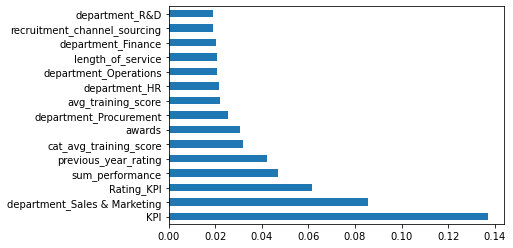

<Figure size 720x720 with 0 Axes>

In [42]:
#Calculating the feature importance

pd.Series(GBModel.feature_importances_,index=data_test_X.columns).sort_values(ascending=False)[:15].plot(kind='barh')
plt.figure(figsize=(10,10))
plt.show()

In [34]:
#Seting the probability thresold to .4
threshold = 0.4

#Train Prediction with Thresold .4
predicted_proba_trn = GBModel.predict_proba(os_data_X)
predicted_trn = (predicted_proba_trn [:,1] >= threshold).astype('int')

print(classification_report(os_data_y, predicted_trn))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     37569
           1       0.99      0.96      0.98     37569

    accuracy                           0.98     75138
   macro avg       0.98      0.98      0.98     75138
weighted avg       0.98      0.98      0.98     75138



In [35]:
#Test Prediction with Thresold .4

predicted_proba_tst = GBModel.predict_proba(data_test_X)
predicted_tst = (predicted_proba_tst [:,1] >= threshold).astype('int')

print(classification_report(data_test_y, predicted_tst))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     12571
           1       0.69      0.42      0.52      1131

    accuracy                           0.94     13702
   macro avg       0.82      0.70      0.74     13702
weighted avg       0.93      0.94      0.93     13702



In [36]:
#Confusion Metrics for Test with thresold .4
gb_rf = confusion_matrix(data_test_y,predicted_tst)
print(gb_rf)

[[12363   208]
 [  661   470]]


In [37]:
#Final Result

In [38]:
final_pred_prob = GBModel.predict_proba(test_data_cleaned)
final_pred = (final_pred_prob [:,1] >= threshold).astype('int')

In [39]:
result = pd.concat([test_data.employee_id ,pd.DataFrame(final_pred, columns = ['is_promoted'])],axis = 1)
result.head()

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0


In [40]:
# Exporting result to CSV

result.to_csv('sample_submission_M0L0uXE.csv',index=False)